# Vocabulary Analysis Workshop

## n-Grams and Sentence Boundary Detection

n-Grams are fixed width sequence of words pulled from a text. Let's use the following sentence as an example.
**Note**: when n is less then 5, they are sometimes given a special name
- 1-gram = unigram
- 2-gram = bigram
- 3-gram = trigram

In [1]:
tokens = 'the quick brown fox jumped over the lazy dog'.split(' ')

n = 1
print('unigrams')
print([tokens[i:i+n] for i in xrange(len(tokens) - n + 1)])

n = 2
print('bigrams')
print([tokens[i:i+n] for i in xrange(len(tokens) - n + 1)])

n = 3
print('trigrams')
print([tokens[i:i+n] for i in xrange(len(tokens) - n + 1)])

n = 4
print('4-grams')
print([tokens[i:i+n] for i in xrange(len(tokens) - n + 1)])

n = 5
print('5-grams')
print([tokens[i:i+n] for i in xrange(len(tokens) - n + 1)])

unigrams
[['the'], ['quick'], ['brown'], ['fox'], ['jumped'], ['over'], ['the'], ['lazy'], ['dog']]
bigrams
[['the', 'quick'], ['quick', 'brown'], ['brown', 'fox'], ['fox', 'jumped'], ['jumped', 'over'], ['over', 'the'], ['the', 'lazy'], ['lazy', 'dog']]
trigrams
[['the', 'quick', 'brown'], ['quick', 'brown', 'fox'], ['brown', 'fox', 'jumped'], ['fox', 'jumped', 'over'], ['jumped', 'over', 'the'], ['over', 'the', 'lazy'], ['the', 'lazy', 'dog']]
4-grams
[['the', 'quick', 'brown', 'fox'], ['quick', 'brown', 'fox', 'jumped'], ['brown', 'fox', 'jumped', 'over'], ['fox', 'jumped', 'over', 'the'], ['jumped', 'over', 'the', 'lazy'], ['over', 'the', 'lazy', 'dog']]
5-grams
[['the', 'quick', 'brown', 'fox', 'jumped'], ['quick', 'brown', 'fox', 'jumped', 'over'], ['brown', 'fox', 'jumped', 'over', 'the'], ['fox', 'jumped', 'over', 'the', 'lazy'], ['jumped', 'over', 'the', 'lazy', 'dog']]


In [2]:
from __future__ import division, print_function

%matplotlib inline

import nltk
import pandas as pd
import pickle

from vocab_analysis import *

import answers

In [3]:
jobs_df = pd.read_pickle('./data/cleaned.pickle')

In [4]:
with open('./data/segments.pickle') as fp:
    segments = pickle.load(fp)

We have a problem though. What if our sequences run across a sentence boundary? Although these ngrams would likely be rare, for low n this can still cause problems. We will need to split our documents into sentences.

NLTK comes function for splitting text into sentences - `PunktSentenceTokenizer`.

(Sentence boundary disambiguation [wikipedia](https://en.wikipedia.org/wiki/Sentence_boundary_disambiguation))  
(PunktTokenizer [docs](http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktSentenceTokenizer))  
(Punkt algorithm [paper](https://www.linguistics.ruhr-uni-bochum.de/~kiss/publications/compling2005_KS27.01final.pdf))

The idea in text segmentation like this is to either find the boundaries, are find the segments. Punkt finds the boundaries by a combination of heuristics and collocation learning for identifying abbreviations.

In [5]:
from my_tokenize import tokenize
from my_lemmatize import lemmatize, english_lemmas
from my_stopword_removal import stopword_removal

In [6]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def lemma_sentences(job_description):
    """
    This function takes a job description and splits it into sentences
    Parameters
    ----------
    job_description : str
        The text of the job description
    Returns
    ----------
    list[str]
        the list of sentences
    """
    sentences = sent_detector.tokenize(job_description)
    return [stopword_removal(lemmatize(tokenize(sentence), english_lemmas)) for sentence in sentences]

In [7]:
jobs_df['sentences'] = jobs_df['description'].apply(lemma_sentences)

In [8]:
with open('./data/segments.pickle') as fp:
    segments = pickle.load(fp)

Now that we sentences, we can generate ngrams.

It worth considering the performance for choose large n.

Although the increase in terms per document is not prohibitive, when this drastically increase the cost of calculating $\mbox{TF.IDF}$ since the terms will be much more sparse. Our data set is small enough that we can got to 5-grams, but for very large corpora trigrams are probably a safer limit.

In [9]:
def ngram_func(n):
    """
    This function creates an ngram extracting function with an appropriate name.
    Parameters
    ----------
    n : int
        the n of the ngrams to be produced
    Returns
    ----------
    Callable[str] -> list[str]
        the ngram generating function
    """
    assert n>1, 'n must be greater than 1'
    def fun(sentences):
        return ['-'.join(ngram) for sentence in sentences for ngram in nltk.ngrams(sentence, n)]
    if n == 2:
        fun.func_name = 'bigrams'
    elif n == 3:
        fun.func_name = 'trigrams'
    else:
        fun.func_name = 'n_{}_grams'.format(n)
    return fun

In [10]:
jobs_df['bigrams'] = jobs_df['sentences'].apply(ngram_func(2))

generating plot 1 / 11
generating plot 2 / 11
generating plot 3 / 11
generating plot 4 / 11
generating plot 5 / 11
generating plot 6 / 11
generating plot 7 / 11
generating plot 8 / 11
generating plot 9 / 11
generating plot 10 / 11
generating plot 11 / 11

('Number of terms: ', 306245)


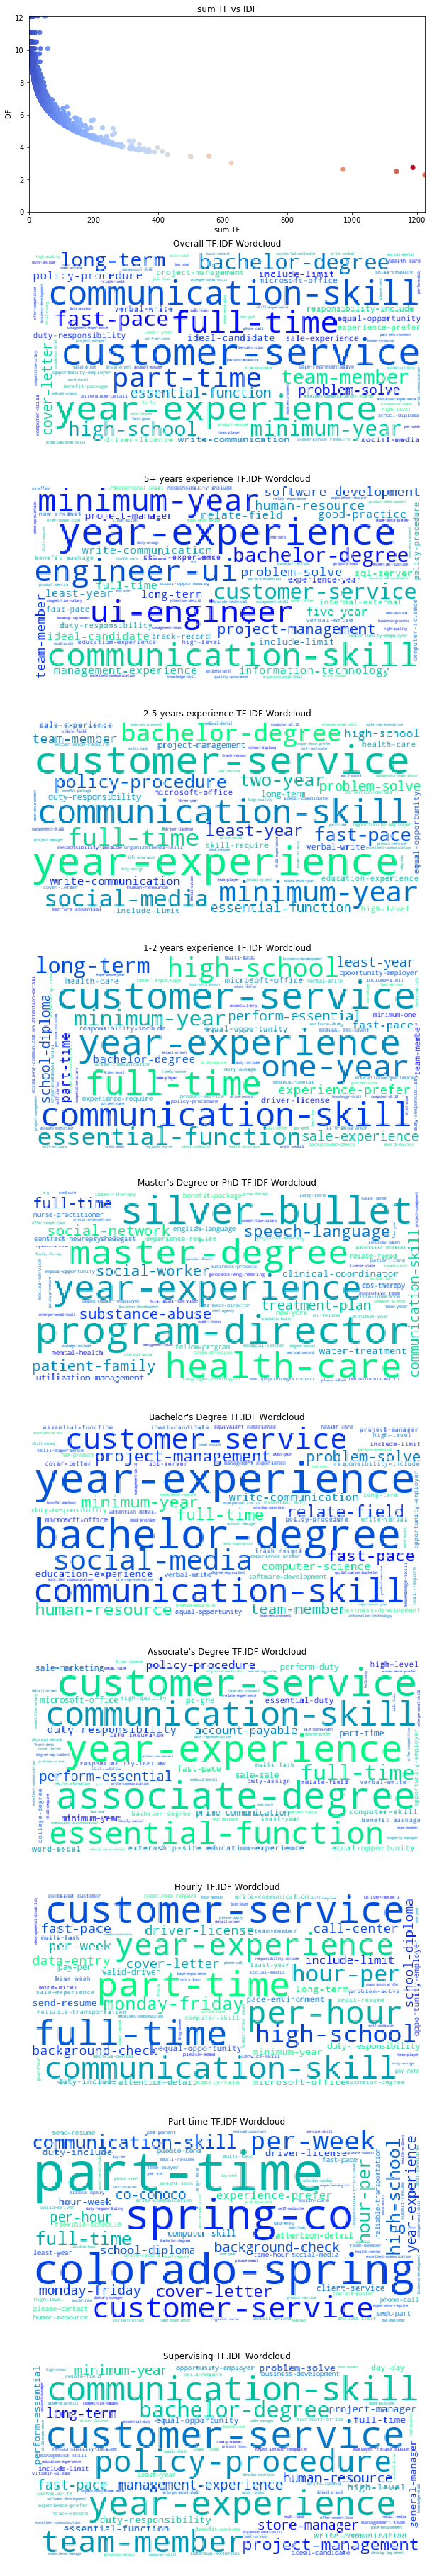

In [11]:
analyze(jobs_df, 'bigrams', segments)

These are even more meaningful than just the stems. However, TF vs IDF plot has become useless. Also, note that our vocabulary has gone from 15817 stems to 288177 bigrams, a 1721% increase.

Observations validating some intuitions
- "year-experi" appears to be more important the more experience is required
- "associ-degre", "bachelor-degre", "master-degre" are important for their respective education levels

There are some oddities
- "silver-bullet" is a prominent bigram for jobs requiring a graduate degree
- "engin-ui" and "ui-engin" are important for jobs requiring 5+ years experience

Let's look at "silver-bullet" oddity

In [12]:
bigram_avg_tfidf_df = calculate_avg_tfidf(jobs_df['bigrams'])
bigram_index, bigram_inv_index = build_indexes(jobs_df['bigrams'])

In [13]:
search(
    "silver bullet", 
    jobs_df['description'], 
    bigram_index, 
    bigram_inv_index, 
    bigram_avg_tfidf_df['idf'],
    lambda q: ngram_func(2)([stopword_removal(lemmatize(tokenize(q), english_lemmas))])
)

1281
Job Description: A Denver based national provider of electro-chemical water treatment systems is hiring a full-time, experienced Operations Manager familiar with the water industry who would lead and manage all facets of the operations of our two main industry groups: Agriculture and Cooling Tower . Silver Bullet rents its patented water conditioning system both directly to clients and through a nationwide network of distributors.  The COO will be responsible for the effective delivery of our products and services to end-users, both directly and through the distribution network, including manufacturing, installation, field operations and troubleshooting, parts replacement (both pro-active and reactive), pre-in-service and post-in-service technical support, ongoing preventative maintenance, reverse logistics and quality improvement.   Job Responsibilities: • Implement and lead a continuous quality improvement process in the two main industry groups, focusing on systems and process 

We see that "Silver Bullet" is a specific company with multiple jobs in our data. This is the danger with n-grams. Because they are more meaningful to our data for larger n, the conclusions are also less generalizable for larger n.

In [14]:
jobs_df['trigrams'] = jobs_df['sentences'].apply(ngram_func(3))

generating plot 1 / 11
generating plot 2 / 11
generating plot 3 / 11
generating plot 4 / 11
generating plot 5 / 11
generating plot 6 / 11
generating plot 7 / 11
generating plot 8 / 11
generating plot 9 / 11
generating plot 10 / 11
generating plot 11 / 11

('Number of terms: ', 491719)


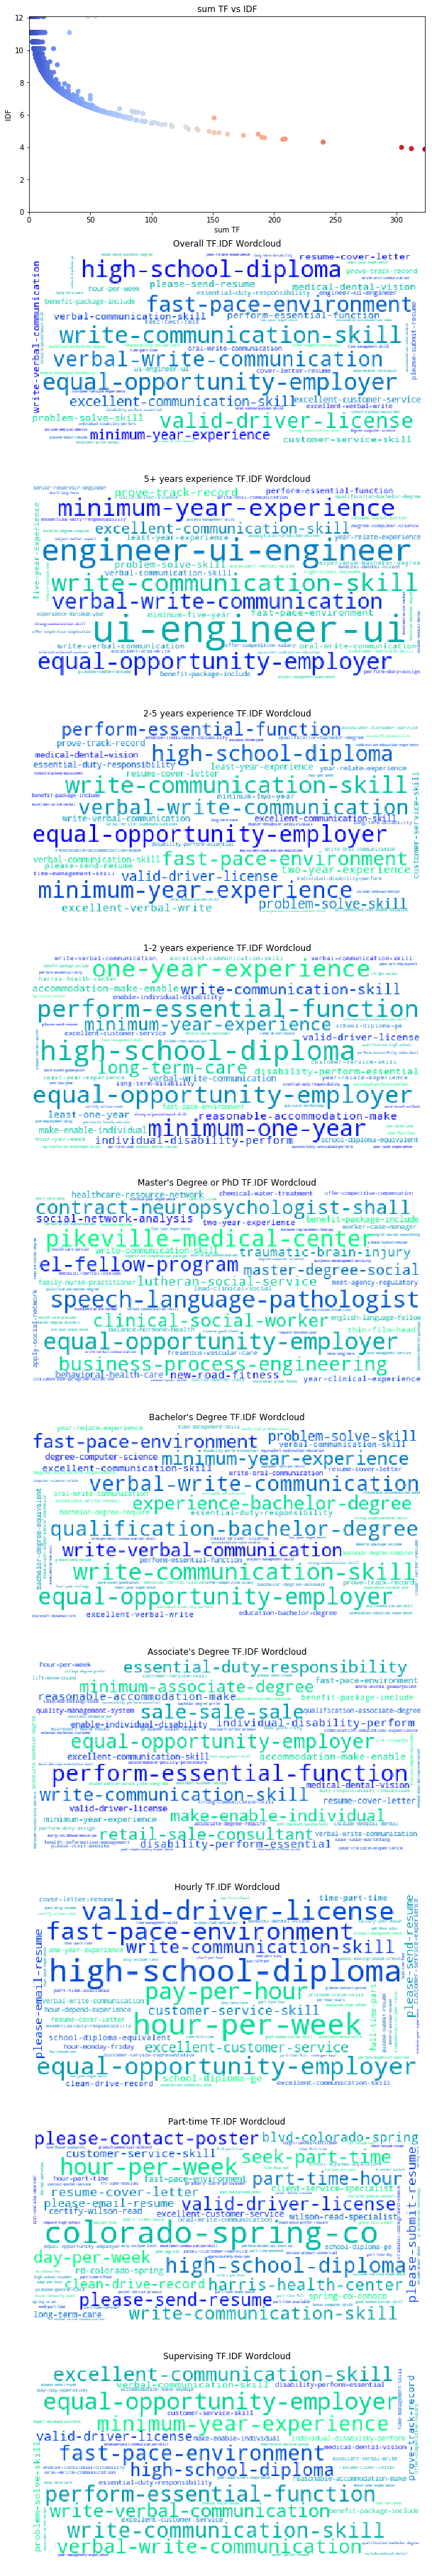

In [15]:
analyze(jobs_df, 'trigrams', segments)

We have 488173 trigrams, a 69% increase from bigrams, and a 2986% increase from stems.

Observations
- There are some formulaic phrases in our data leading to "equal-opportun-employ" being prominent in all segments
- "high-school-diploma", "hours-per-week", and "valid-driver-licens" are prominent for hourly jobs

Oddities
- "colorado-spring-co" is prominent for some segments, this certainly not generalizable 
- "engin-ui-engin" and "ui-engin-ui" are prominent for jobs requireing 5+ years of experience

Let's look into the "engin-ui-engin" oddity

In [16]:
trigram_avg_tfidf_df = calculate_avg_tfidf(jobs_df['trigrams'])
trigram_index, trigram_inv_index = build_indexes(jobs_df['trigrams'])

In [17]:
search(
    "engineer ui engineer", 
    jobs_df['description'], 
    trigram_index, 
    trigram_inv_index, 
    trigram_avg_tfidf_df['idf'],
    lambda q: ngram_func(3)([stopword_removal(lemmatize(tokenize(q), english_lemmas))])
)

1001
UI Engineer – Medallia    “JOIN US IN THE FIGHT AGAINST MEDIOCRITY!”    Right now we have massive amounts of data with very little structure, which is why we’re putting together a core team of software engineers who just happen to work on UI.  This team is going to redefine our user experience and at the same time set the standard for how the world interacts with big data.  We’re really looking to create custom real-time interactions through amazing visualizations using the latest web technologies.    Medallia is the global leader in SaaS Customer Experience Management and Enterprise Feedback Management.  We build technology that captures and analyzes ridiculous amounts of structured or unstructured data for our customers in real-time.  Basically, we help businesses better understand their customers which leads to customer loyalty and market dominance.  We were recently named a Leader in EFM Satisfaction and Loyalty Solutions in the first-ever Wave Report by Forrester Research.   

If you look at the bottom of the description, you will see a classic search engine optimization (SEO) tactic - repeating key words to boost your $\mbox{TF}$ for some keywords.

Although this is an oddity, it is valuable information. If one were attempting classify jobs by industry, how might these repeats affect the modeling?

In [18]:
jobs_df['quadrigrams'] = jobs_df['sentences'].apply(ngram_func(4))

generating plot 1 / 11
generating plot 2 / 11
generating plot 3 / 11
generating plot 4 / 11
generating plot 5 / 11
generating plot 6 / 11
generating plot 7 / 11
generating plot 8 / 11
generating plot 9 / 11
generating plot 10 / 11
generating plot 11 / 11

('Number of terms: ', 497154)


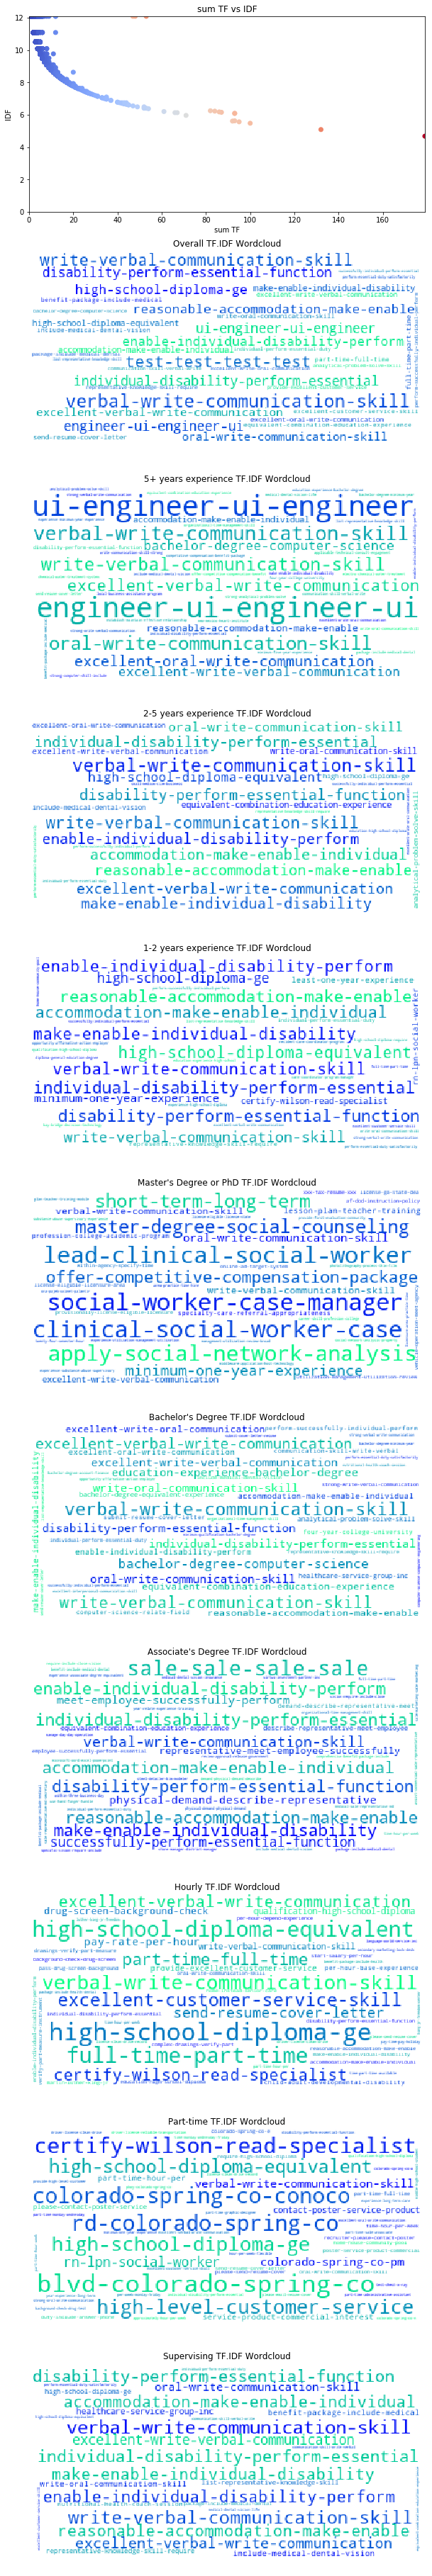

In [19]:
analyze(jobs_df, 'quadrigrams', segments)

We now have 496144 4-grams, a 2% increase from trigrams.

Observations
- formulaic phrases have almost completely taken over
- social work appears to be prominent type of job in our data

Oddities
- "sale-sale-sale-sale" appears, is likely another instance of SEO

In [20]:
quadrigram_avg_tfidf_df = calculate_avg_tfidf(jobs_df['quadrigrams'])
quadrigram_index, quadrigram_inv_index = build_indexes(jobs_df['quadrigrams'])

In [21]:
search(
    "sale sale sale sale", 
    jobs_df['description'], 
    trigram_index, 
    trigram_inv_index, 
    trigram_avg_tfidf_df['idf'],
    lambda q: ngram_func(3)([stopword_removal(lemmatize(tokenize(q), english_lemmas))])
)

103
Sales Representative Position for Credit Union Sales    Direct Hire/Permanent Position + Competitive Salary + Outstanding Benefits +  Career Advancement Potential = Career Happiness and Success for you!        Imagine yourself doing exciting and rewarding sales work.    You will be paid handsomely for work you love doing.    You will love working for this phenomenally successful, stable and rapidly growing company that specializes in marketing financial services to credit union members.      You will enjoy many benefits in this plum position including:    -Competitive base salary with a multi-level bonus structure  -Career advancement and financial incentives  -Paid training and licensing  -Hours you can live with   -Excellent benefit package including:  Medical/Dental insurance, as well as Life Insurance and Short Term Disability Coverage  401(k) Retirement plan with company match  10 Paid holidays in addition to vacation time, and much more...    The hiring manager is hoping you 

## Conclusion

What have we learned about our data set?

- We should be able to distinguish between our segments using stems with stop words removed, and bigrams of the stems.
- Some jobs are using SEO to boost their $\mbox{TF}$
- Sales, social work, medical work are common types in our data
- Colorado appears to be overrepresented in our data
- There are certain stems that appear common across all segments
  - "manag" - "manage", "management", "manager"
  - "experi" - "experience", "experienced", "experiment"
  - "sale" - "sale", "sales"
  - "servic" - "service", "services"
  

In [22]:
save_fun(lemma_sentences, imports=['nltk'], star_imports=['my_tokenize', 'my_lemmatize', 'my_stopword_removal'], 
         sent_detector=sent_detector)
save_fun(ngram_func, imports=['nltk'])

In [23]:
jobs_df.to_pickle('./data/ngrams.pickle')

Now, let's take what we've learned and try and apply it to model-building

### NEXT => [7. Modeling](7. Modeling.ipynb)